/home/onizuka/.local/share/virtualenvs/onizuka-9mceCfC_/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


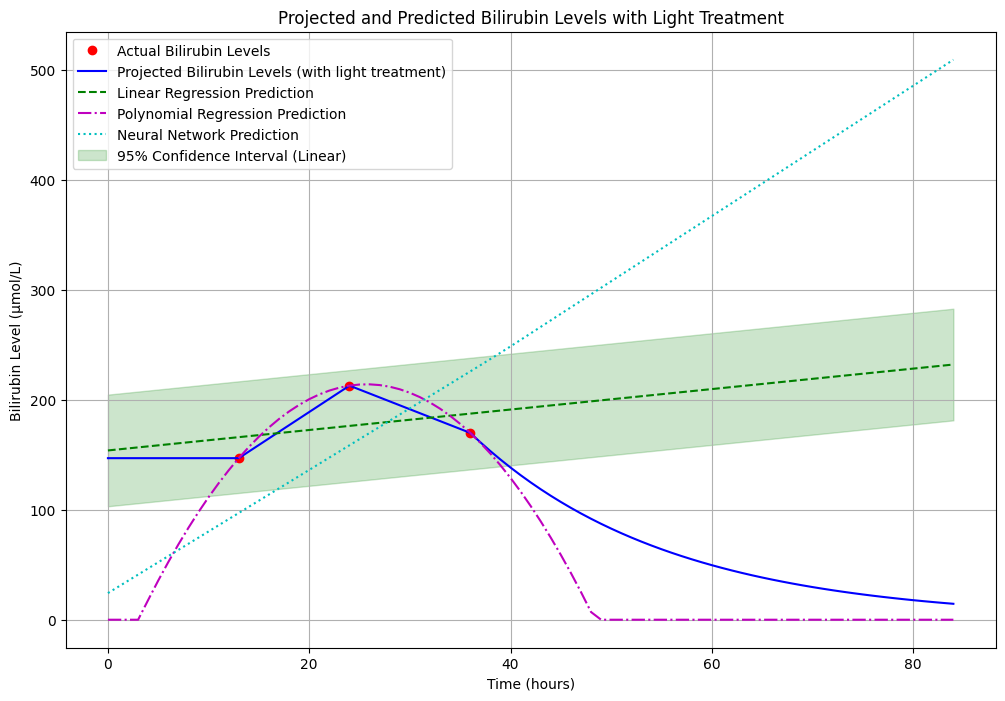

   Hours  Projected Levels  Linear Prediction  Polynomial Prediction  \
0      0             147.0         154.018892                    0.0   
1      1             147.0         154.949622                    0.0   
2      2             147.0         155.880353                    0.0   
3      3             147.0         156.811083                    0.0   
4      4             147.0         157.741814                   18.0   

   Neural Network Prediction  
0                  24.218978  
1                  29.835253  
2                  35.451528  
3                  41.065135  
4                  46.677492  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor

# Data points
hours = np.array([13, 24, 36])
bilirubin_levels = np.array([147, 213, 170])

# Use a linear interpolation for simplicity
df = pd.DataFrame({'hours': hours, 'bilirubin_levels': bilirubin_levels})
df.set_index('hours', inplace=True)

# Resample to interpolate values
projected_hours = np.arange(0, 85, 1)
projected_levels = np.interp(projected_hours, df.index, df['bilirubin_levels'])

# Apply a hypothetical decay function for light treatment effect
decay_rate = 0.05  # assuming 5% decrease per hour due to treatment
for i in range(len(projected_levels)):
    if projected_hours[i] > 36:  # assuming treatment starts after 36 hours
        projected_levels[i] = max(0, projected_levels[i - 1] * (1 - decay_rate))

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(hours.reshape(-1, 1), bilirubin_levels)
linear_pred = linear_model.predict(projected_hours.reshape(-1, 1))
linear_pred = np.clip(linear_pred, 0, None)  # Prevent negative values

# Polynomial Regression Model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(hours.reshape(-1, 1))
poly_model = LinearRegression()
poly_model.fit(X_poly, bilirubin_levels)
poly_pred = poly_model.predict(poly.fit_transform(projected_hours.reshape(-1, 1)))
poly_pred = np.clip(poly_pred, 0, None)  # Prevent negative values

# Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, activation='relu')
nn_model.fit(hours.reshape(-1, 1), bilirubin_levels)
nn_pred = nn_model.predict(projected_hours.reshape(-1, 1))
nn_pred = np.clip(nn_pred, 0, None)  # Prevent negative values

# Plotting the data and the models
plt.figure(figsize=(12, 8))

# Actual and projected levels
plt.plot(hours, bilirubin_levels, 'ro', label='Actual Bilirubin Levels')
plt.plot(projected_hours, projected_levels, 'b-', label='Projected Bilirubin Levels (with light treatment)')

# Model predictions
plt.plot(projected_hours, linear_pred, 'g--', label='Linear Regression Prediction')
plt.plot(projected_hours, poly_pred, 'm-.', label='Polynomial Regression Prediction')
plt.plot(projected_hours, nn_pred, 'c:', label='Neural Network Prediction')

# Adding confidence intervals for linear regression
linear_std = np.std(bilirubin_levels - linear_model.predict(hours.reshape(-1, 1)))
confidence_interval = 1.96 * linear_std
plt.fill_between(projected_hours, np.clip(linear_pred - confidence_interval, 0, None), linear_pred + confidence_interval, color='g', alpha=0.2, label='95% Confidence Interval (Linear)')

plt.xlabel('Time (hours)')
plt.ylabel('Bilirubin Level (μmol/L)')
plt.title('Projected and Predicted Bilirubin Levels with Light Treatment')
plt.legend()
plt.grid(True)
plt.show()

# Creating a combined DataFrame for detailed analysis
predicted_data = pd.DataFrame({
    'Hours': projected_hours,
    'Projected Levels': projected_levels,
    'Linear Prediction': linear_pred,
    'Polynomial Prediction': poly_pred,
    'Neural Network Prediction': nn_pred
})

# Display the combined DataFrame
print(predicted_data.head())  # Display first few rows for verification
